In [ ]:
## Kütüphaneleri import etmek

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input


In [ ]:
## Drive bağlantısı

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Veri seti yolu
data_path = "/content/drive/MyDrive/Colab Notebooks/malmo_one_year.csv"

In [ ]:
## Veri setini okumak

df = pd.read_csv(data_path)
df.head()

,dt_iso,temp,humidity,wind_speed,clouds_all,pressure,dew_point
0,2022-12-31 23:00:00+00:00,282.10,92,0.45,100,998,280.87
1,2023-01-01 00:00:00+00:00,282.06,94,2.30,100,998,281.15
2,2023-01-01 01:00:00+00:00,282.45,96,3.30,100,997,281.85
3,2023-01-01 02:00:00+00:00,283.25,95,4.50,100,997,282.49
4,2023-01-01 03:00:00+00:00,283.06,96,13.40,100,997,282.45


In [ ]:
df.shape

(8761, 7)

In [ ]:
## Eksik değer kontrolü

df.isnull().sum().sum()

np.int64(0)

In [ ]:
df.describe()


,temp,humidity,wind_speed,clouds_all,pressure,dew_point
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,282.988909,77.431686,4.575376,64.264011,1009.922612,278.979982
std,6.986704,14.166828,3.190479,37.641924,12.008072,6.231148
min,265.430000,30.000000,0.000000,0.000000,966.000000,262.360000
25%,277.410000,68.000000,2.200000,29.000000,1001.000000,274.220000
50%,282.190000,81.000000,4.050000,80.000000,1011.000000,278.630000
75%,289.070000,89.000000,6.200000,100.000000,1019.000000,284.210000
max,299.900000,100.000000,25.200000,100.000000,1041.000000,293.840000


In [ ]:
## Kelvin'i Celcius'a dönüştürmek

df["temp_celcius"] = df["temp"] - 273.15

In [ ]:
df[["temp","temp_celcius"]].head()

,temp,temp_celcius
0,282.10,8.95
1,282.06,8.91
2,282.45,9.30
3,283.25,10.10
4,283.06,9.91


In [ ]:
## Tarih dönüşümü

df["date"] = pd.to_datetime(df["dt_iso"]).dt.date

In [ ]:
df[["date","dt_iso"]].head()

,date,dt_iso
0,2022-12-31,2022-12-31 23:00:00+00:00
1,2023-01-01,2023-01-01 00:00:00+00:00
2,2023-01-01,2023-01-01 01:00:00+00:00
3,2023-01-01,2023-01-01 02:00:00+00:00
4,2023-01-01,2023-01-01 03:00:00+00:00


In [ ]:
## Gereksiz sütunları çıkarmak

df = df.drop(columns=["dt_iso","temp"])

In [ ]:
## Zaman serisi veriyle çalışırken "date" değişkeninin sıralı olduğuna emin olmamız gerekiyor.

df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celcius,date
0,92,0.45,100,998,280.87,8.95,2022-12-31
1,94,2.30,100,998,281.15,8.91,2023-01-01
2,96,3.30,100,997,281.85,9.30,2023-01-01
3,95,4.50,100,997,282.49,10.10,2023-01-01
4,96,13.40,100,997,282.45,9.91,2023-01-01


In [ ]:
## "date" değişkenin sıralı olup olmadığına bu şekilde bakabiliriz.

df["date"].is_monotonic_increasing

True

In [ ]:
## "date" değişkeni sıralı değilse bu şekilde sıralı hale getirebiliriz.

## df.set_index("date", inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   humidity      8761 non-null   int64  
 1   wind_speed    8761 non-null   float64
 2   clouds_all    8761 non-null   int64  
 3   pressure      8761 non-null   int64  
 4   dew_point     8761 non-null   float64
 5   temp_celcius  8761 non-null   float64
 6   date          8761 non-null   object 
dtypes: float64(3), int64(3), object(1)
memory usage: 479.2+ KB


In [ ]:
## "date" değişkeni object olarak gözüküyor.Modellemeye geçmeden önce index bilgisini zaman bilgisine göndermemiz gerekiyor.
## pandasın anlayacağı şekilde bu bir zaman değişkenidir diye belirtmemiz gerekiyor.

df["date"] = pd.to_datetime(df["date"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   humidity      8761 non-null   int64         
 1   wind_speed    8761 non-null   float64       
 2   clouds_all    8761 non-null   int64         
 3   pressure      8761 non-null   int64         
 4   dew_point     8761 non-null   float64       
 5   temp_celcius  8761 non-null   float64       
 6   date          8761 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 479.2 KB


In [ ]:
## date bilgisini indexe göndermemiz gerekiyor.

df.set_index("date", inplace = True)

In [ ]:
df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celcius
date,,,,,,
2022-12-31,92,0.45,100,998,280.87,8.95
2023-01-01,94,2.30,100,998,281.15,8.91
2023-01-01,96,3.30,100,997,281.85,9.30
2023-01-01,95,4.50,100,997,282.49,10.10
2023-01-01,96,13.40,100,997,282.45,9.91


In [ ]:
df.index.max()

Timestamp('2023-12-31 00:00:00')

In [ ]:
df.index.min()

Timestamp('2022-12-31 00:00:00')

Bu veri seti bir yıllık saatlik veri setidir. Peki biz saatlik veri setiyle mi çalışmalıyız yoksa günlük veri setiyle mi çalışmalıyız?

Eğer saatlik veri setiyle çalışıyor olursak bu daha hassas tahminlerde bulunabileceğimiz anlamına gelir ve kısa süreli hava değişikliklerini daha iyi yakalayabileceğimiz anlamına gelir.
* Özellikle hava durumu değişkenliğinin yüksek olduğu durumlarda fayda sağlayabilir.
* Ancak çok daha fazla veri gerektirir ve modelin eğitim süresi çok daha uzun olacaktır.Kaynak kullanımı artacaktır.

In [ ]:
## bu method orijinal saatlik veriyi günlük veriye dönüştürür.
## çıktımız her bir günlük değişkenin ortalamasını içerir.

df = df.resample("D").mean()

In [ ]:
## nasıl kolayca resample'I uygulayabildi? DataFrame'in indexine baktı.
## "date" değişkeni varsa bu "date" e göre günlük formatta diğer bütün değişkenlerin ortalamasını alacağını anladı.

df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celcius
date,,,,,,
2022-12-31,92.000000,0.450000,100.000000,998.000000,280.870000,8.950000
2023-01-01,90.791667,8.787500,96.000000,1003.916667,281.007917,9.292917
2023-01-02,93.500000,7.887500,91.833333,1008.041667,279.700833,7.535000
2023-01-03,87.083333,8.070833,46.500000,1018.583333,275.953333,4.784583
2023-01-04,94.958333,11.200000,99.791667,1003.166667,278.899583,6.497083


In [ ]:
## Zaman Serisi Görselleştirme Fonksiyonu

def plot_time_series(data, columns=None, figsize=(12, 6)):

    """
    Zaman serisi verilerini görselleştirir.

    Parametreler:
    - data (pd.DataFrame): Zaman serisi verilerini içeren DataFrame.
    - columns (list, optional): Çizilecek sütunların listesi. Belirtilmezse tüm sütunlar çizilir.
    - figsize (tuple): Çizim alanının boyutu (genişlik, yükseklik).
    """
    if columns is None:
        columns = data.columns
    plt.figure(figsize=figsize)

    for column in columns:
        plt.plot(data.index, data[column], label=column)
    plt.title('Time Series Visualisation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()

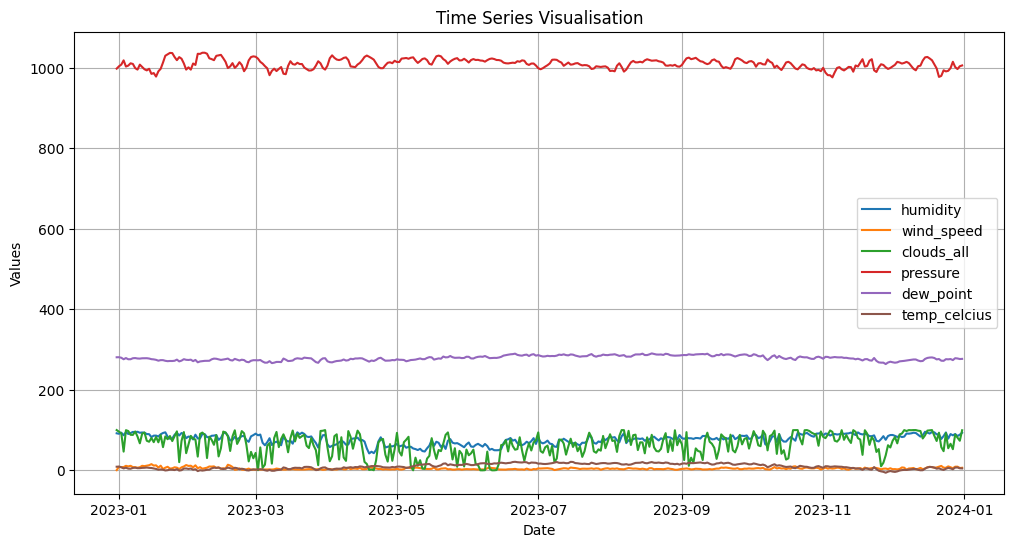

In [ ]:
plot_time_series(df)

In [ ]:
## bu fonksiyon DataFrame içerisindeki değişkenleri ayrı ayrı görselleştirir.

def plot_individual_series(data, figsize=(12, 4)):
    for column in data.columns:
        plt.figure(figsize=figsize)
        plt.plot(data.index, data[column], label=column, color='b')
        plt.title(f'Time Series Visualisation - {column}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()
        plt.show()

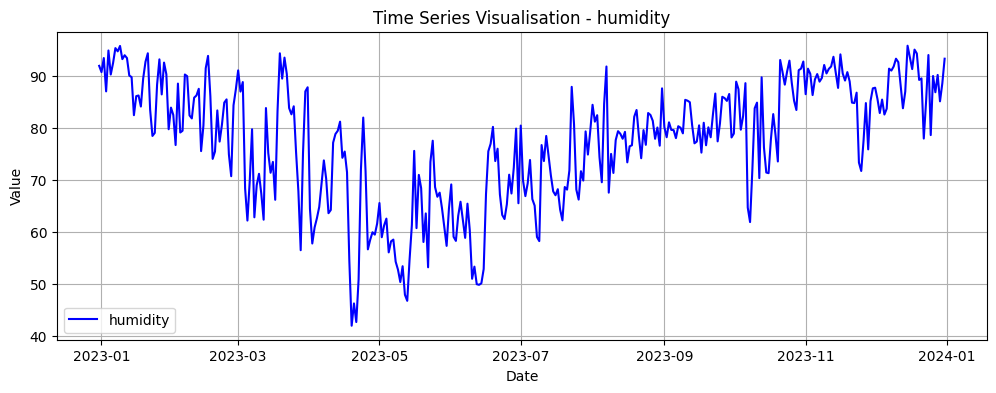

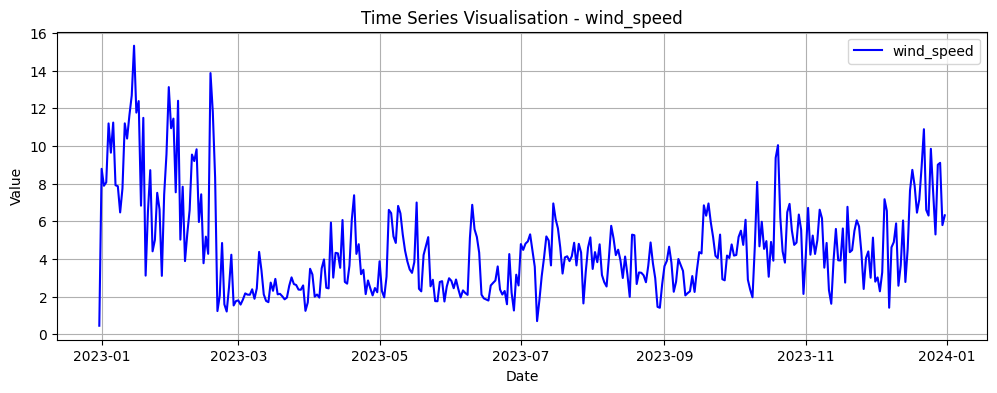

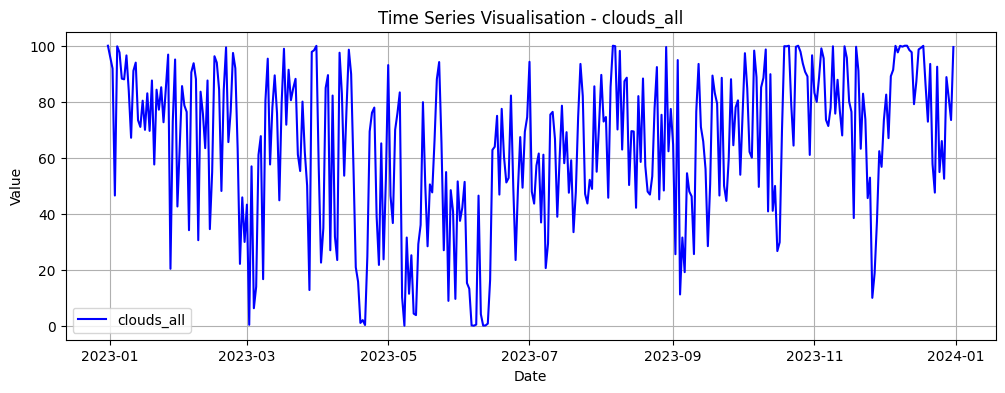

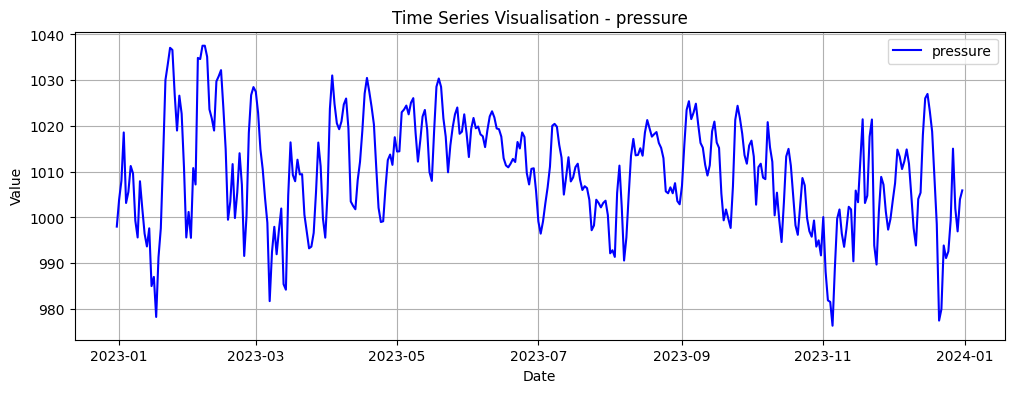

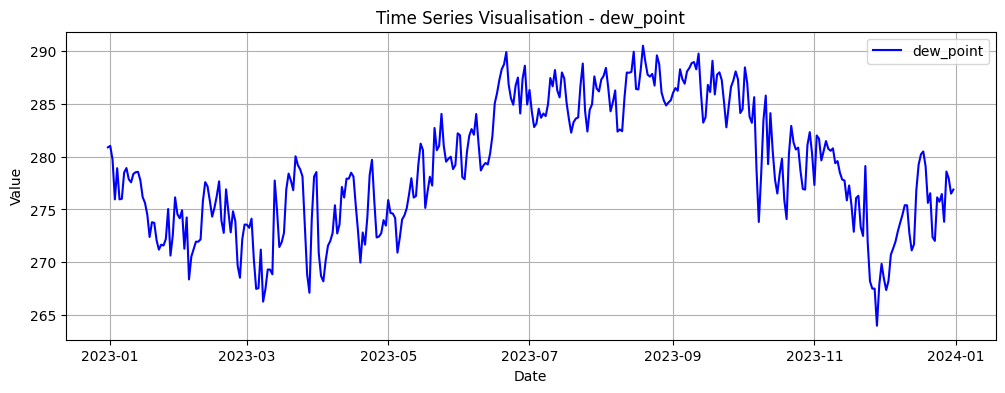

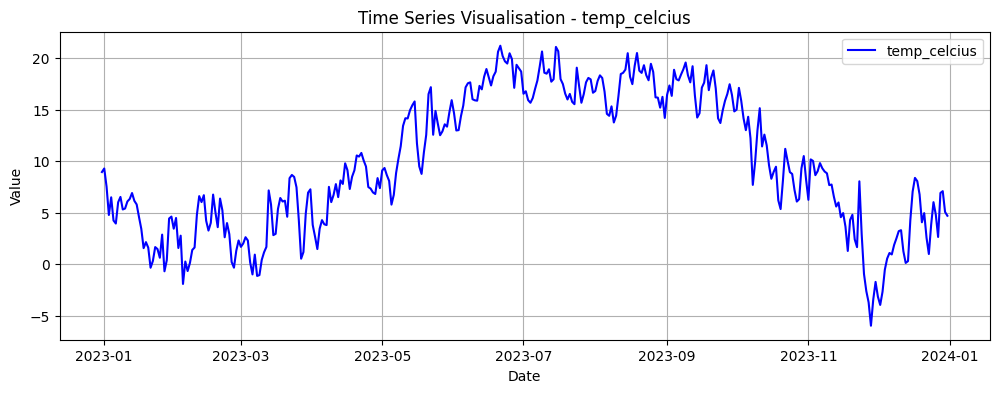

In [ ]:
plot_individual_series(df)

In [ ]:
## Korelasyon Matrisi Görselleştirme Fonksiyonu

def plot_correlation_matrix(data):
    corr_matrix = data.corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Correlation Matris')
    plt.show()

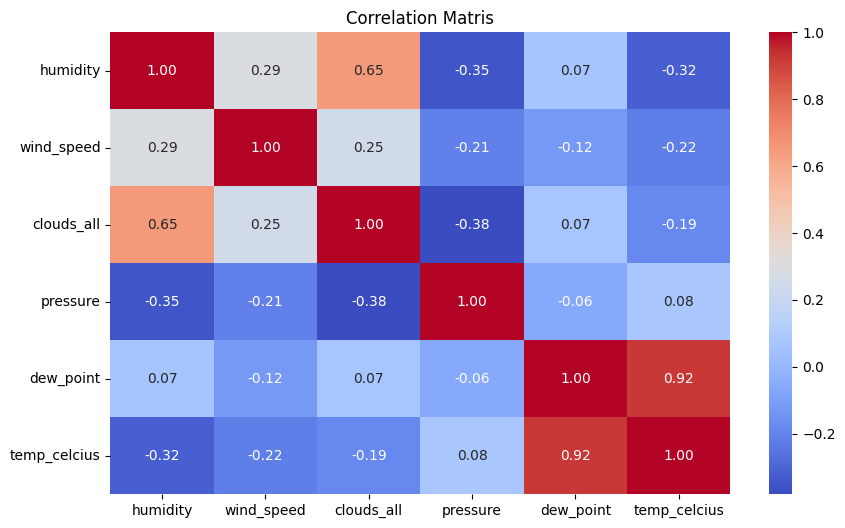

In [ ]:
plot_correlation_matrix(df)

In [ ]:
## Anomali Tespiti Fonksiyonu

def plot_with_anomalies(data, anomalies, column, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.plot(data.index, data[column], label=f'Normal {column}')
    plt.scatter(anomalies.index, anomalies[column], color='red', label='Anomaly', zorder=5)
    plt.title(f'{column} Over Time with Anomalies Highlighted')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for column in df.columns:
  df[column + "_zscore"] = zscore(df[column])

In [ ]:
df.head()

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celcius,humidity_zscore,wind_speed_zscore,clouds_all_zscore,pressure_zscore,dew_point_zscore,temp_celcius_zscore
date,,,,,,,,,,,,
2022-12-31,92.000000,0.450000,100.000000,998.000000,280.870000,8.950000,1.222333,-1.614215,1.309496,-1.020266,0.313226,-0.134474
2023-01-01,90.791667,8.787500,96.000000,1003.916667,281.007917,9.292917,1.120684,1.656723,1.162537,-0.512624,0.336142,-0.082461
2023-01-02,93.500000,7.887500,91.833333,1008.041667,279.700833,7.535000,1.348519,1.303638,1.009454,-0.158704,0.118956,-0.349096
2023-01-03,87.083333,8.070833,46.500000,1018.583333,275.953333,4.784583,0.808725,1.375563,-0.656084,0.745757,-0.503735,-0.766269
2023-01-04,94.958333,11.200000,99.791667,1003.166667,278.899583,6.497083,1.471200,2.603186,1.301842,-0.576973,-0.014181,-0.506523


In [ ]:
## df'i filtrele.
## içerisinde "zscore" ifadesi geçen değişkenlere odaklan.Bu değişkenlerin mutlak değerini hesapla.
## 3'ten büyük olan gözlem birimlerini getir.
## Herhangi bir tanesinde varsa

anomalies = df[(df.filter(like= "zscore").abs() > 3).any(axis=1)]

In [ ]:
anomalies

,humidity,wind_speed,clouds_all,pressure,dew_point,temp_celcius,humidity_zscore,wind_speed_zscore,clouds_all_zscore,pressure_zscore,dew_point_zscore,temp_celcius_zscore
date,,,,,,,,,,,,
2023-01-14,89.833333,12.683333,71.000000,997.625000,277.757500,6.155833,1.040065,3.185122,0.244041,-1.052441,-0.203952,-0.558283
2023-01-15,82.500000,15.329167,80.375000,985.000000,276.165833,5.806250,0.423157,4.223125,0.588477,-2.135649,-0.468426,-0.611306
2023-01-17,86.291667,12.387500,83.000000,978.250000,274.508333,3.433333,0.742127,3.069061,0.684919,-2.714791,-0.743838,-0.971222
2023-01-30,79.791667,13.130417,42.583333,995.625000,274.557500,4.628750,0.195322,3.360520,-0.799982,-1.224038,-0.735669,-0.789905
2023-02-03,88.583333,12.404167,76.375000,1007.208333,274.243333,2.775833,0.934910,3.075600,0.441518,-0.230203,-0.787871,-1.070949
2023-02-17,86.166667,13.875000,84.375000,999.500000,277.657083,6.762083,0.731611,3.652632,0.735436,-0.891568,-0.220637,-0.466329


In [ ]:
total_anomalies = len(anomalies)
print(f"Toplam anomali sayısı: {total_anomalies}")

Toplam anomali sayısı: 6


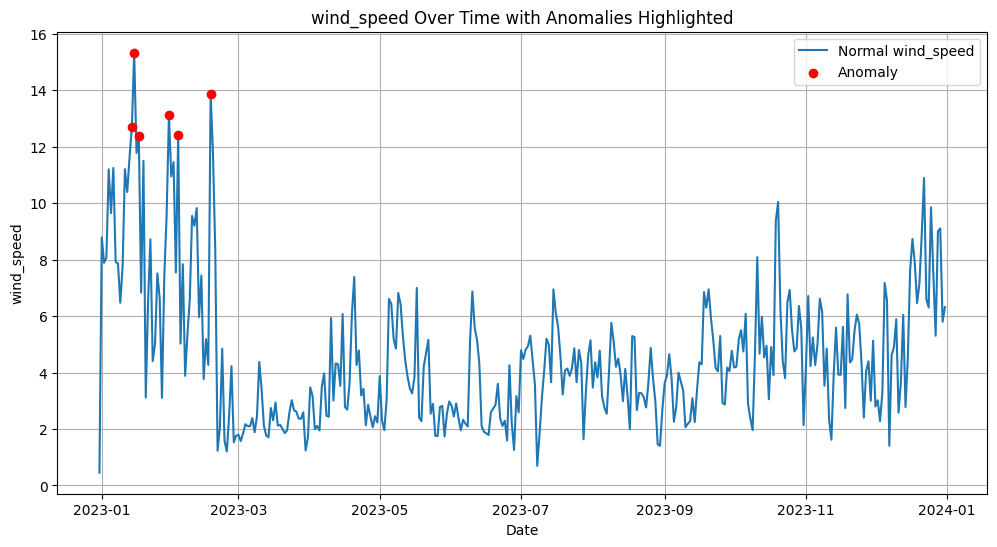

In [ ]:
plot_with_anomalies(df, anomalies, "wind_speed")

In [ ]:
n = len(df)

In [ ]:
## Train,validation,test size ayarlama

train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

In [ ]:
train_df = df[:train_size]
val_df = df[train_size: train_size + val_size]
test_df = df[train_size + val_size:]

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(256, 12) (54, 12) (56, 12)


In [ ]:
## Standartlaştırma

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [ ]:
## Özellik ve Hedef Değişken Ölçeklendirme

feature_columns =[col for col in  df.columns if "temp_celcius" not in col and "zscore" not in col]
target_column = "temp_celcius"

scaler_x.fit(train_df[feature_columns])
train_scaled_x = scaler_x.transform(train_df[feature_columns])
val_scaled_x = scaler_x.transform(val_df[feature_columns])
test_scaled_x = scaler_x.transform(test_df[feature_columns])

scaler_y.fit(train_df[[target_column]])
train_scaled_y = scaler_y.transform(train_df[[target_column]])
val_scaled_y = scaler_y.transform(val_df[[target_column]])
test_scaled_y = scaler_y.transform(test_df[[target_column]])



In [ ]:
## Time step: 10
## Day: [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
## Temp: [15,16,14,17,18,16,19,20,21,22,23,21,20,24,25 ]

## First Window:
## X: 15,16,14,17,18,16,19,20,21,22
## Y: 23

## Second Window:
## X: 16,14,17,18,16,19,20,21,22,23
## Y: 21

## Third Window:
## X: 14,17,18,16,19,20,21,22,23,21
## Y: 20

In [ ]:
## Time step:3

## Before

## Day: [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
## Temp: [15,16,14,17,18,16,19,20,21,22,23,21,20,24,25]

## After

## X = [
    [15, 16, 14],
    [16, 14, 17],
    [14, 17, 18],
    [17, 18, 16],
    [18, 16, 19],
    [16, 19, 20],
    [19, 20, 21],
    [20, 21, 22],
    [21, 22, 23],
    [22, 23, 21],
    [23, 21, 20],
    [21, 20, 24]
]

## Y = [17,18,16,19,20,21,22,23,21,20,24,25]

## Time Window
* Belirli bir periyottaki geçmiş dönem gözlemlerini seçmek için kullanılır.

In [ ]:
## Zaman Serisi Veri Kümesi Oluşturma Fonksiyonu

def create_dataset(X,y, time_steps = 1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X[i:(i + time_steps), :]
    Xs.append(v)
    ys.append(y[i + time_steps])
  return np.array(Xs), np.array(ys)


In [ ]:
## Window Size ile ile Zaman Serisi Veri Kümesi Oluşturma

window_size = 5
X_train, y_train = create_dataset(train_scaled_x, train_scaled_y.ravel(), window_size)
X_val, y_val = create_dataset(val_scaled_x, val_scaled_y.ravel(), window_size)
X_test, y_test = create_dataset(test_scaled_x, test_scaled_y.ravel(), window_size)

In [ ]:
df.shape

(366, 12)

In [ ]:
print(train_scaled_x[0], train_scaled_y[0])

[0.92884764 0.         1.         0.33309909 0.60295334] [0.46978547]


In [ ]:
X_train[0]

array([[0.92884764, 0.        , 1.        , 0.33309909, 0.60295334],
       [0.90641918, 0.56034724, 0.96      , 0.43288826, 0.6086567 ],
       [0.95668987, 0.49985998, 0.91833333, 0.50245959, 0.55460404],
       [0.83758701, 0.51218146, 0.465     , 0.68025299, 0.39963126],
       [0.9837587 , 0.7224867 , 0.99791667, 0.42023893, 0.52146943]])

In [ ]:
y_train[0]

np.float64(0.26643230575085664)

In [ ]:
## Veri setinde kaç değişken var ve pencereye boyu kaç?

input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
input_shape

(5, 5)

In [ ]:
## Train setindeki gözlem sayısı = 0.index

X_train.shape[0]

251

In [ ]:
## Window bilgisi

X_train.shape[1]

5

In [ ]:
## Değişken sayısı bilgisi

X_train.shape[2]

5

In [ ]:
## Aktivasyon bilgisi vermedik. Identity function.Regresyon problemindeyiz ve target sayısal bir değişken.

input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),
    SimpleRNN(50, input_shape = input_shape),  ## 50 nöron
    Dense(1)
])

In [ ]:
## Model Derleme: Adam Optimizer ve MSE Kayıp Fonksiyonu

model.compile(optimizer="adam",
              loss = "mean_squared_error",
              metrics= ["mse"])

In [ ]:
## Model Eğitimi

history = model.fit(
    X_train, y_train,
    epochs = 50,
    validation_data = (X_val, y_val),
    batch_size = 32,
    verbose = 1
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1397 - mse: 0.1397 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - mse: 0.0128 - 

In [ ]:
## Eğitim Geçmişi Görselleştirme Fonksiyonu

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

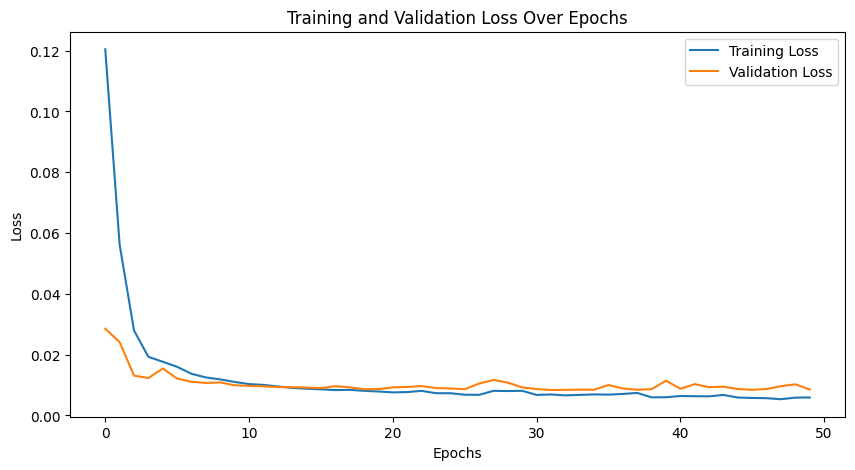

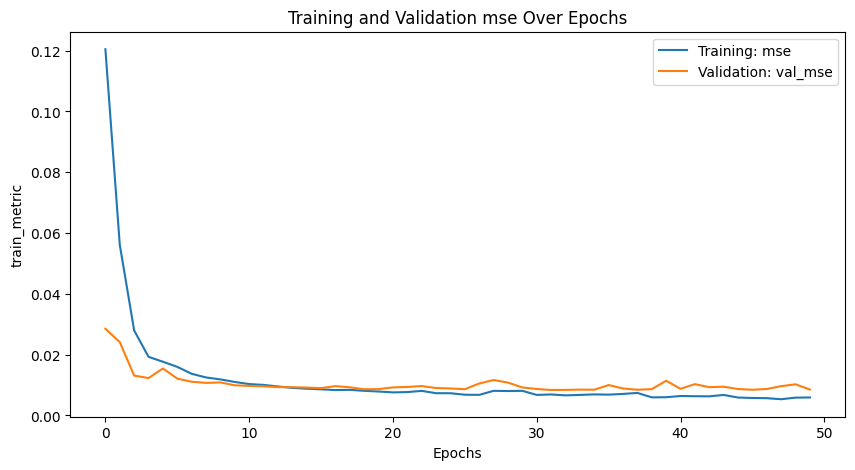

In [ ]:
plot_training_history(history, train_loss='loss', train_metric='mse', val_loss='val_loss', val_metric='val_mse')

In [ ]:
## Model Kayıp Değerlerinin Hesaplanması ve Yazdırılması

train_loss = model.evaluate(X_train, y_train, verbose = 0)
val_loss = model.evaluate(X_val, y_val, verbose = 0)
test_loss = model.evaluate(X_test, y_test, verbose = 0)
print(f"Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Loss: 0.005240472964942455 Validation Loss: 0.008506651036441326 Test Loss: 0.010974489152431488


In [ ]:
## Model Tahminlerinin Oluşturulması

y_train_pred = model.predict(X_train, verbose = 0)
y_val_pred = model.predict(X_val, verbose = 0)
y_test_pred = model.predict(X_test, verbose = 0)

In [ ]:
y_train_pred[0:5]


array([[0.475722  ],
       [0.33373764],
       [0.30789453],
       [0.29892582],
       [0.305286  ]], dtype=float32)

In [ ]:
y_val_pred[0:5]

array([[0.84050983],
       [0.85777307],
       [0.7976043 ],
       [0.80046767],
       [0.8475904 ]], dtype=float32)

In [ ]:
y_test_pred[0:5]

array([[0.42309415],
       [0.39856115],
       [0.36924863],
       [0.37067947],
       [0.36821225]], dtype=float32)

In [ ]:
## Tahminlerin Ölçeklendirmenin Tersine Çevrilmesi

true_y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

true_y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1))

true_y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))

In [ ]:
true_y_train_pred[0:5]

array([[9.087208 ],
       [5.8055944],
       [5.208296 ],
       [5.001006 ],
       [5.148006 ]], dtype=float32)

In [ ]:
## Gerçek Değerlerin Ölçeklendirmenin Tersine Çevrilmesi

true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))

true_y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
true_y_train[0:5]

array([[4.25      ],
       [3.95291667],
       [6.01416667],
       [6.53541667],
       [5.3175    ]])

In [ ]:
## Ölçeklenmiş MSE Metriklerinin Hesaplanması ve Yazdırılması

train_mse = mean_squared_error(true_y_train, true_y_train_pred)

val_mse = mean_squared_error(true_y_val, true_y_val_pred)

test_mse = mean_squared_error(true_y_test, true_y_test_pred)

print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)

Train MSE: 2.79939646380561 Validation MSE: 4.544145372552149 Test MSE: 5.862436379665849


In [ ]:
df["temp_celcius"].mean()

np.float64(9.836581284153027)

In [ ]:
true_y_test[-10:]

array([[2.57583333],
       [0.99708333],
       [3.85208333],
       [6.02541667],
       [4.815     ],
       [2.65      ],
       [6.9225    ],
       [7.09541667],
       [5.07583333],
       [4.70875   ]])

In [ ]:
true_y_test_pred[-10:]

array([[5.1027994],
       [2.478335 ],
       [2.8423314],
       [2.864541 ],
       [2.3225443],
       [5.6291   ],
       [3.4639337],
       [5.4448404],
       [6.0574083],
       [5.887858 ]], dtype=float32)

In [ ]:
## Gerçek ve Tahmin Edilen Değerlerin Görselleştirilmesi Fonksiyonu

def plot_predictions(time, true_values, predictions, title):
    plt.figure(figsize=(15, 5))
    plt.plot(time, true_values, label='True Values')
    plt.plot(time, predictions, label='Predicted Values', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Temp')
    plt.legend()
    plt.grid(True)
    plt.show()

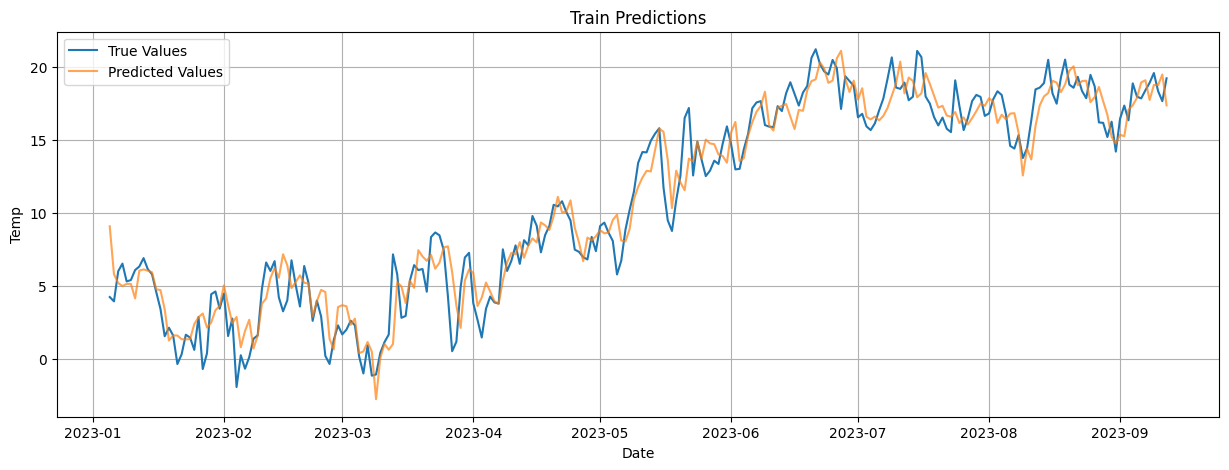

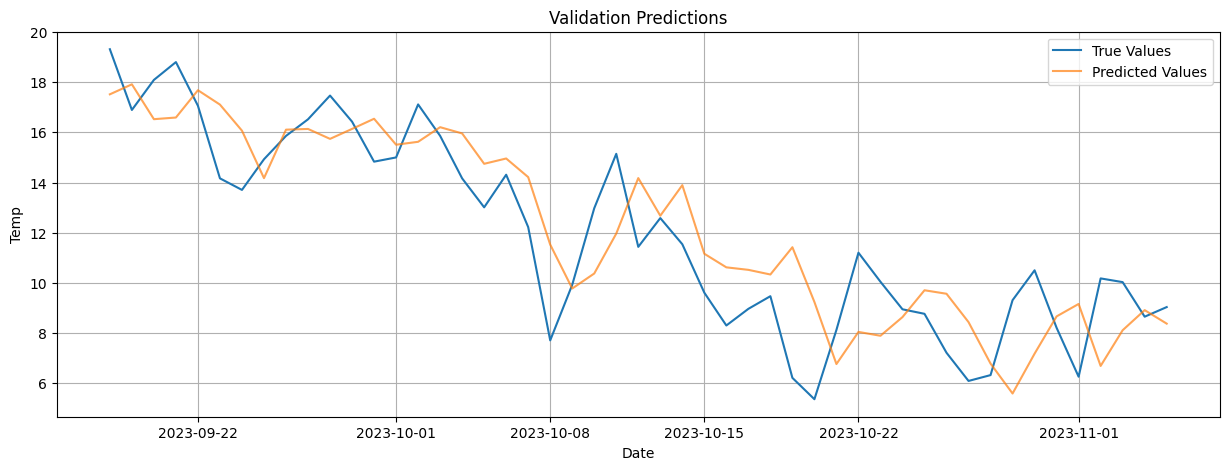

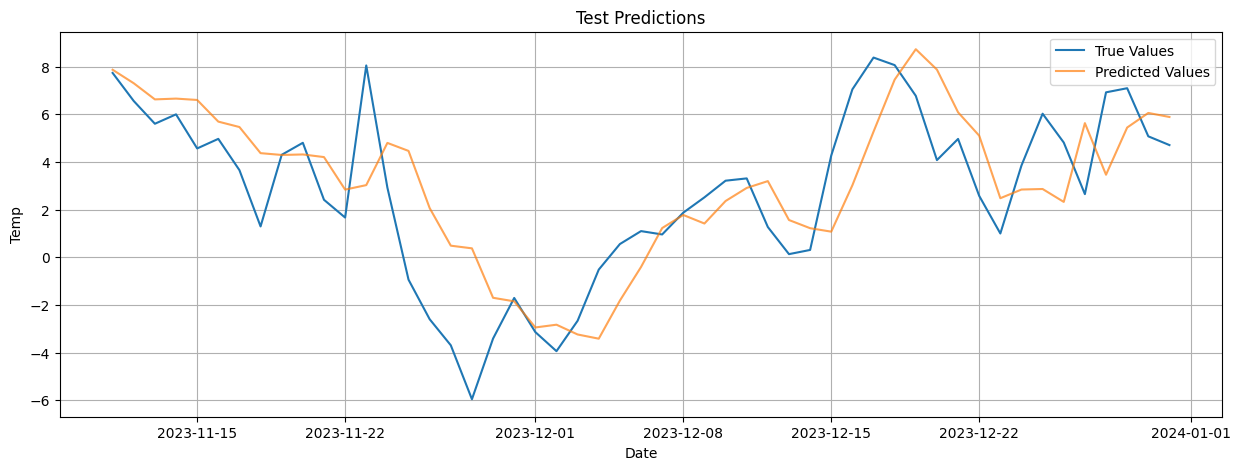

In [ ]:
time_train = train_df.index[window_size:]

time_val = val_df.index[window_size:]

time_test = test_df.index[window_size:]

plot_predictions(time_train, true_y_train, true_y_train_pred, 'Train Predictions')


plot_predictions(time_val, true_y_val, true_y_val_pred, 'Validation Predictions')

plot_predictions(time_test, true_y_test, true_y_test_pred, 'Test Predictions')

In [ ]:
## Tüm Veri Kümeleri için Gerçek ve Tahmin Değerlerinin Görselleştirilmesi

def plot_all_predictions(train_df, val_df, test_df, window_size,
                     true_y_train, true_y_train_pred,
                     true_y_val, true_y_val_pred,
                     true_y_test, true_y_test_pred):

    plt.figure(figsize=(20, 10))

    # train
    train_time = train_df.index[window_size:]
    plt.plot(train_time, true_y_train, label='True Values (Train)', color='blue')
    plt.plot(train_time, true_y_train_pred, '--', label='Predicted Values (Train)', color='red')

    # validation
    val_time = val_df.index[window_size:]
    plt.plot(val_time, true_y_val, label='True Values (Validation)', color='green')
    plt.plot(val_time, true_y_val_pred, '--', label='Predicted Values (Validation)', color='orange')

    # test
    test_time = test_df.index[window_size:]
    plt.plot(test_time, true_y_test, label='True Values (Test)', color='purple')
    plt.plot(test_time, true_y_test_pred, '--', label='Predicted Values (Test)', color='pink')

    plt.title('Actual and Predicted Values for All Data Sets')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

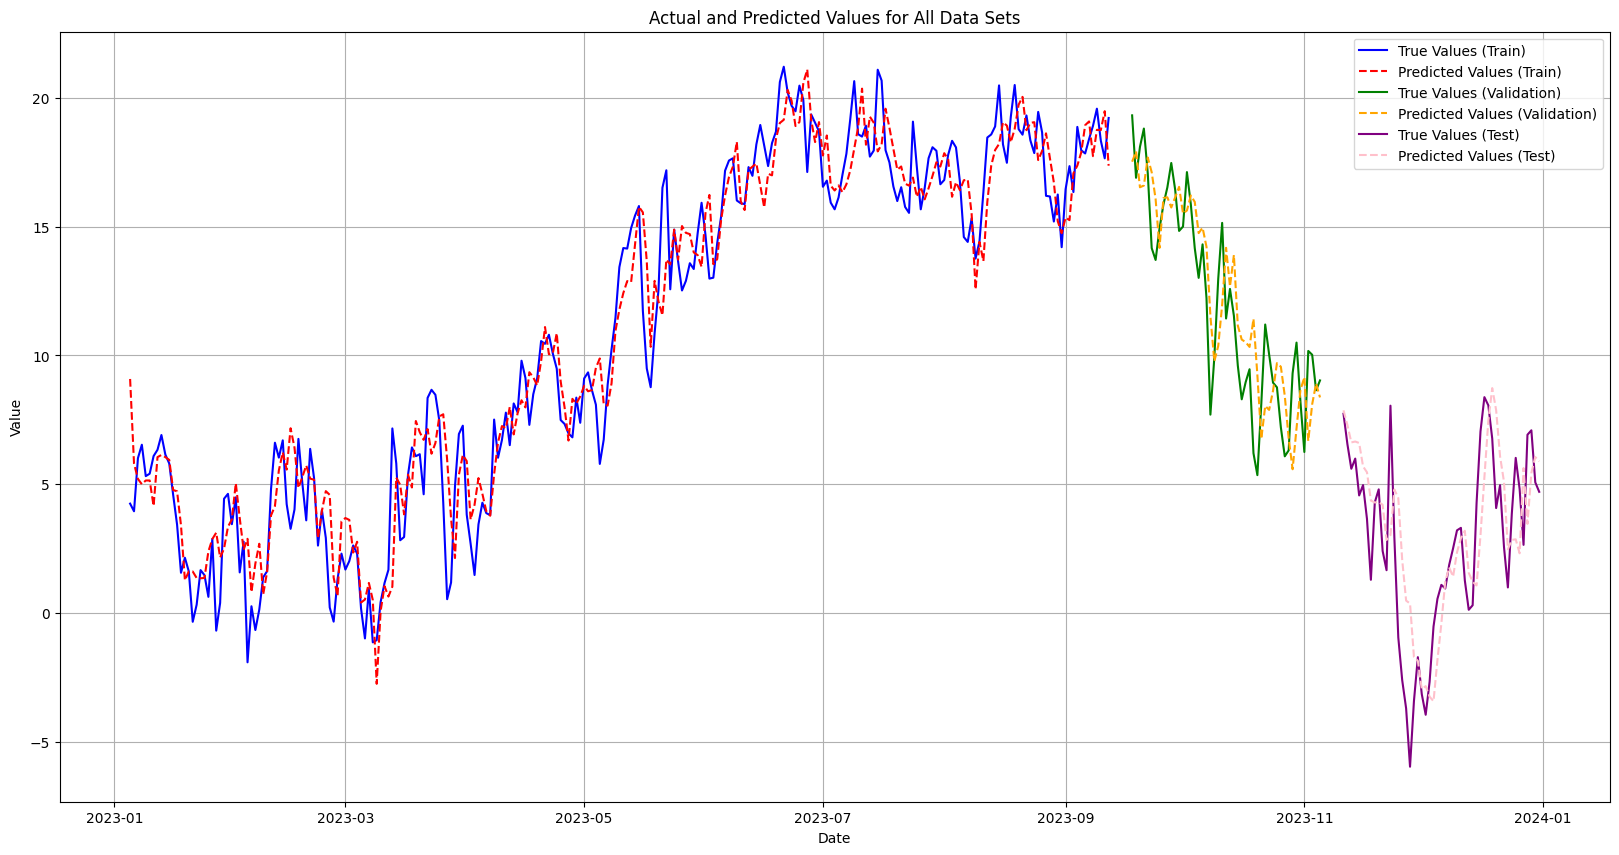

In [ ]:
plot_all_predictions(train_df=train_df,
                 val_df=val_df,
                 test_df=test_df,
                 window_size=window_size,
                 true_y_train=true_y_train,
                 true_y_train_pred=true_y_train_pred,
                 true_y_val=true_y_val,
                 true_y_val_pred=true_y_val_pred,
                 true_y_test=true_y_test,
                 true_y_test_pred=true_y_test_pred)